In [1]:
import numpy as np
import pandas as pd 

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from analysis_preprocess import Preprocessing, FeatureImportance, realtorpredict
from datetime import datetime


C:\Windows\Temp\ipykernel_5124\821198876.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
rawtrain = pd.read_csv('train.csv')
rawtest = pd.read_csv('test.csv')
preprocesseddata = Preprocessing(rawtrain, rawtest)

train = preprocesseddata.wrangletrain()
test = preprocesseddata.wrangletest()

D:\Sean\Documents\GitHub\Tabular Data\House Price Prediction\analysis_preprocess.py:252: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data['MasVnrArea'].fillna(0, inplace=True)
D:\Sean\Documents\GitHub\Tabular Data\House Price Prediction\analysis_preprocess.py:255: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

Dropping index 948 because of this weird row
Value when BsmtExposure is NA but BsmtFinSF1 and BsmtUnfSF is not NA
BsmtFinSF1      0
BsmtUnfSF     936
Name: 948, dtype: int64
fixing column LotArea in test data to fit format int64
fixing column YearBuilt in test data to fit format int64
fixing column YearRemodAdd in test data to fit format int64
fixing column BsmtFinSF1 in test data to fit format int64
fixing column BsmtFinSF2 in test data to fit format int64
fixing column BsmtUnfSF in test data to fit format int64
fixing column TotalBsmtSF in test data to fit format int64
fixing column 1stFlrSF in test data to fit format int64
fixing column 2ndFlrSF in test data to fit format int64
fixing column LowQualFinSF in test data to fit format int64
fixing column GrLivArea in test data to fit format int64
fixing column BsmtFullBath in test data to fit format int64
fixing column BsmtHalfBath in test data to fit format int64
fixing column FullBath in test data to fit format int64
fixing column Hal

In [3]:
rawtrain.select_dtypes(include = 'object').isna().sum()

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

In [4]:
X, y = train.drop("SalePrice",axis = 1), train['SalePrice']
y = np.log1p(y)

In [5]:
# defining error functions for handy use. 
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [6]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [7]:
#Distance-based Learners
ridge = RidgeCV(alphas=alphas_alt, cv=kfolds)
lasso = LassoCV(max_iter=10000000, alphas=alphas2, random_state=42, cv=kfolds)
elasticnet = ElasticNetCV(max_iter=10000000, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio)

#Tree-based Learners
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)       
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=5000,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

## Stacking models

In [8]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Comparing models

In [9]:
# Using various prediction models that we just created
score = cv_rmse(elasticnet, X)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(ridge, X)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso, X)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr, X)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost, X)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm, X)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


elastic net: 0.1500 (0.0350)
 2024-01-30 16:19:52.587403
RIDGE: 0.1505 (0.0346)
 2024-01-30 16:20:09.299148
LASSO: 0.1498 (0.0346)
 2024-01-30 16:20:15.780626
gbr: 0.1370 (0.0175)
 2024-01-30 16:22:53.811421
xgboost: 0.1271 (0.0177)
 2024-01-30 16:24:45.129500
lightgbm: 0.1368 (0.0164)
 2024-01-30 16:25:00.590949


In [10]:
print('START Fit')
print("============ Fitting against original training data for each model ============")

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
                                          
print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
============ Fitting against original training data for each model ============
stack_gen
elasticnet
Lasso
Ridge
GradientBoosting
xgboost
lightgbm


# Ensembling

In [11]:
weightelastic = 0.05
weightlasso = 0.05
weightridge = 0.05
weightgbr = 0.1
weightxgb = 0.2
weightlgb = 0.1
weightstack = 0.45

In [12]:
def blend_models_predict(X):
    return ((weightelastic * elastic_model_full_data.predict(X)) + \
            (weightlasso * lasso_model_full_data.predict(X)) + \
            (weightridge * ridge_model_full_data.predict(X)) + \
            (weightgbr * gbr_model_full_data.predict(X)) + \
            (weightxgb * xgb_model_full_data.predict(X)) + \
            (weightlgb * lgb_model_full_data.predict(X)) + \
            (weightstack * stack_gen_model.predict(np.array(X))))    


In [13]:
print('RMSE score on train data:')
print(rmse(y, blend_models_predict(X)))

RMSE score on train data:
0.048566179385403516


# Feature Importance

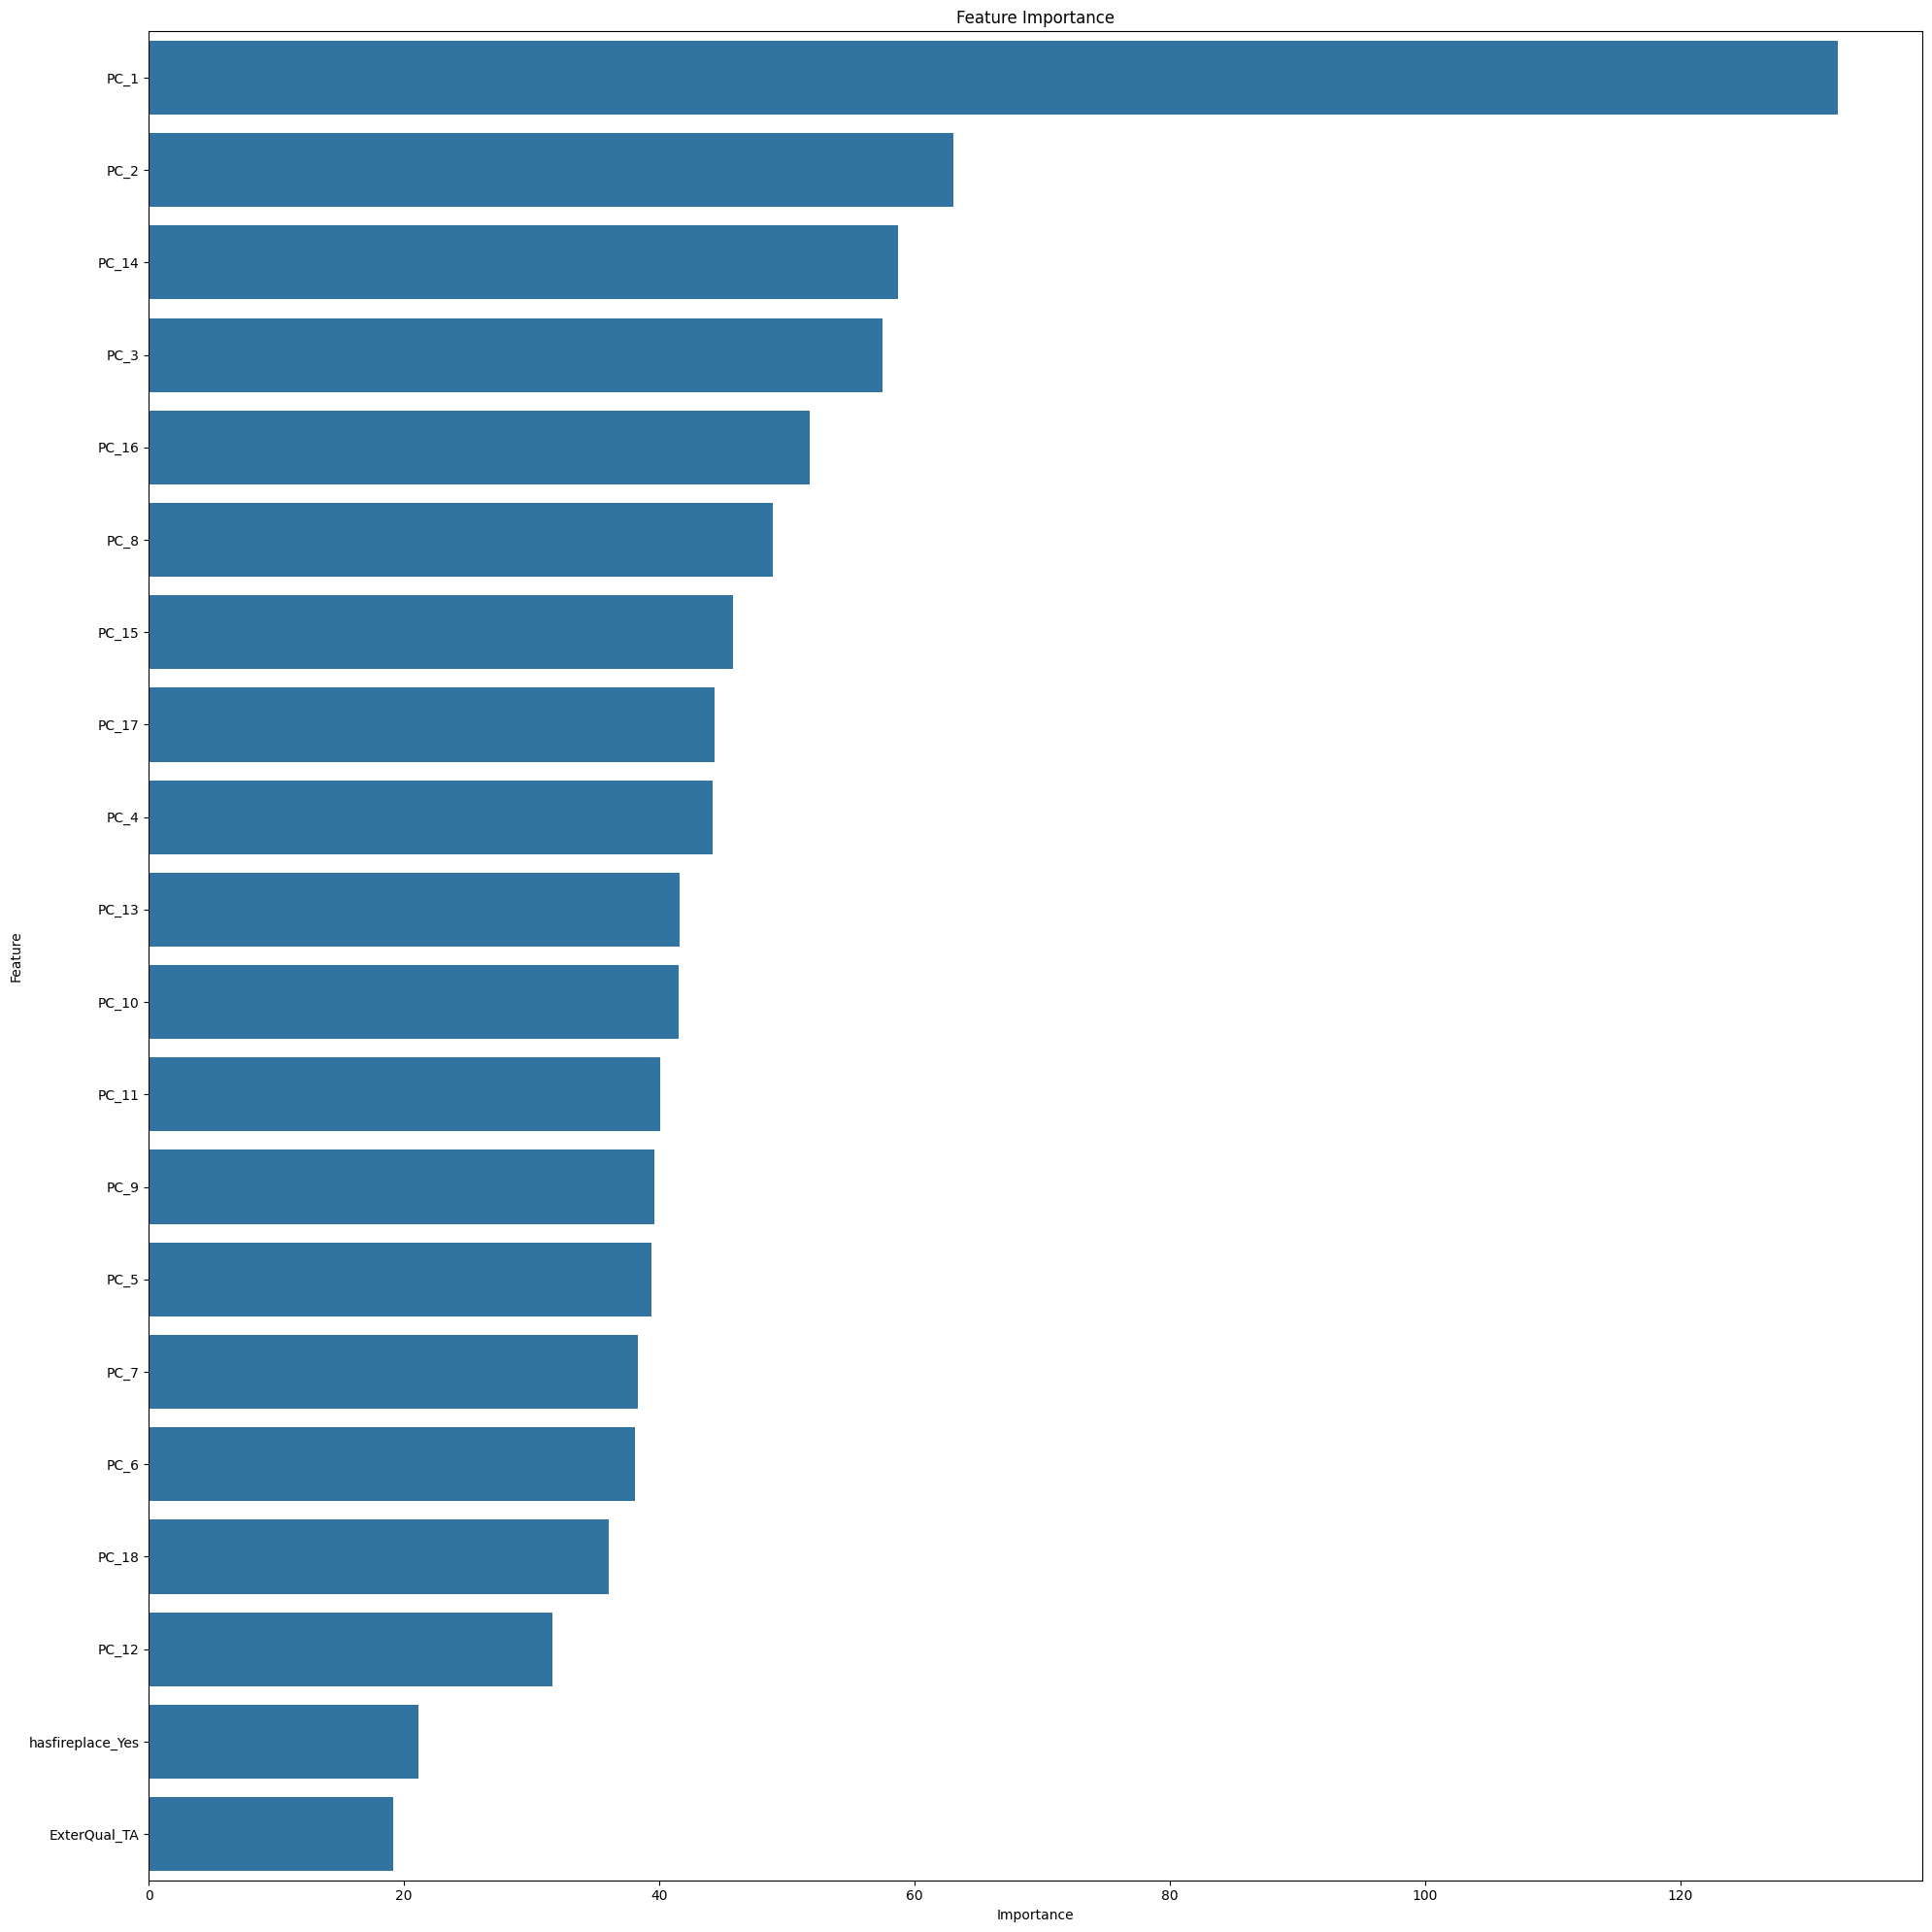

In [14]:
FI = FeatureImportance(elastic_model_full_data,
                       lasso_model_full_data,
                       ridge_model_full_data,
                       gbr_model_full_data,
                       xgb_model_full_data,
                       lgb_model_full_data,
                       X)
FItable = FI.getfeatureimportance(weightelastic,
                                  weightlasso,
                                  weightridge,
                                  weightgbr,
                                  weightxgb,
                                  weightlgb)
FI.plotfeatureimportance(FItable.head(20))

# Cost Benefit

Supposedly there's an average realtor that specifically knows the average price of a house by knowing its Neighborhood, MSZoning, Condition1, Condition2, BldgType, HouseStyle, Utilities, BsmtCond, GarageCond, SaleType, and SaleCondition.

In [15]:
predictedtable = realtorpredict(rawtrain)

print('RMSE score of model on train data (Log):')
print(rmse(np.log1p(predictedtable['SalePrice']), blend_models_predict(X)))
print('RMSE score of model on train data (Dollars):')
print(rmse(predictedtable['SalePrice'], np.expm1(blend_models_predict(X))))
print("="*10)
print('RMSE score of realtor on train data (Log):')
print(rmse(np.log1p(predictedtable['SalePrice']), np.log1p(predictedtable['PredictedSalePrice'])))
print('RMSE score of realtor on train data (Dollars:')
print(rmse(predictedtable['SalePrice'], predictedtable['PredictedSalePrice']))

D:\Sean\Documents\GitHub\Tabular Data\House Price Prediction\analysis_preprocess.py:539: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BsmtCond'] = df['BsmtCond'].fillna('NA')
D:\Sean\Documents\GitHub\Tabular Data\House Price Prediction\analysis_preprocess.py:540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GarageCond'] = df['GarageCond'].fillna('NA')


RMSE score of model on train data (Log):
0.048566179385403516
RMSE score of model on train data (Dollars):
9864.014675152966
RMSE score of realtor on train data (Log):
0.16001737133489835
RMSE score of realtor on train data (Dollars:
37597.231447963684


Suppose that everytime we predict less than ground truth, we sustain financial loss and everytime we predict more than the ground truth, we are able to sell the property but without considering whether the final price differ from the predicted price or not.

In [16]:
#evaluating loss profit
totalmodel = np.where(predictedtable['SalePrice']>np.expm1(blend_models_predict(X)), predictedtable['SalePrice'] - np.expm1(blend_models_predict(X)), 0)
totalrealtor = np.where(predictedtable['SalePrice']>predictedtable['PredictedSalePrice'],predictedtable['SalePrice'] - predictedtable['PredictedSalePrice'],0)

lossprofmodel = np.sum(totalmodel)
lossprofrealtor = np.sum(totalrealtor)

print('Loss Profit Valuation (By Ensemble Model): $'+"{:,.2f}".format(lossprofmodel))
print('Loss Profit Valuation (By Realtor): $'+"{:,.2f}".format(lossprofrealtor))

Loss Profit Valuation (By Ensemble Model): $5,189,526.49
Loss Profit Valuation (By Realtor): $14,814,162.80


# Submission

In [17]:
print('Predict submission')
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = (np.expm1(blend_models_predict(test)))

Predict submission


In [18]:
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)
# Quantiles helping us get some extreme values for extremely low or high values 
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission.csv", index=False)

<Axes: xlabel='SalePrice', ylabel='Count'>

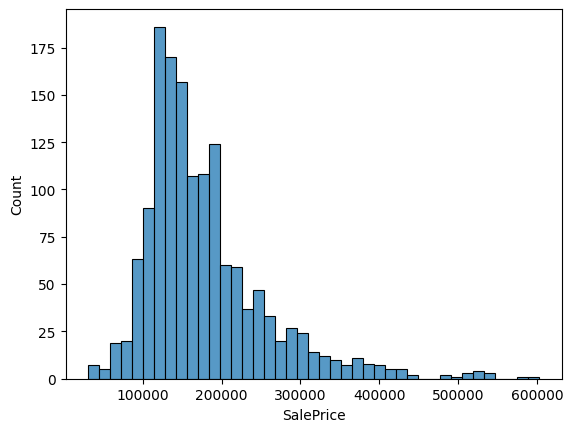

In [19]:
import seaborn as sns
sns.histplot(submission['SalePrice'])

In [20]:
submission.head()

,Id,SalePrice
0,1461,116683.115725
1,1462,155574.928451
2,1463,179832.007215
3,1464,192274.010930
4,1465,183325.763757
